In [1]:
import numpy as np
import pandas as pd

import os
import pickle as pkl
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

import autokeras as ak # !pip install autokeras

import json

import matplotlib.pyplot as plt

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

2023-02-02 17:08:05.663367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 17:08:06.192566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ivv101/arrayfire/lib64:/usr/local/cuda/lib64:/home/ivv101/arrayfire/lib64:/usr/local/cuda/lib64::/home/ivv101/miniconda3/envs/p310/lib/:/home/ivv101/miniconda3/envs/p310/lib/
2023-02-02 17:08:06.192663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# tf.keras.backend.binary_crossentropy??

In [3]:
# y_true = np.array([[1, 1, 0], [1, 1, 1]])
# y_pred = np.array([[1, 0, 1], [1, 0, 0]]).astype(float)


# bce_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# # bce_func(y_true, y_pred).numpy()


# target = y_true
# output = y_pred

# epsilon_ = tf.keras.backend.epsilon()

# output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)

# bce = target * tf.math.log(output + epsilon_)
# bce += (1 - target) * tf.math.log(1 - output + epsilon_)

# -bce.numpy(), bce_func(y_true, y_pred).numpy()

In [4]:
# import tensorflow as tf
# from tensorflow.keras.layers import *
# from tensorflow.keras import Model
# import numpy as np

# a = np.random.randint(10,size=(10,20,1))
# b = np.random.rand(10,15)
# train_dataset = tf.data.Dataset.from_tensor_slices((a,b)).batch(4)

# inp = Input(shape=(None,), dtype="int32")
# embedding = Embedding(12, 300, trainable=False, mask_zero=True)(inp)
# gru = Bidirectional(GRU(128, recurrent_dropout=0.5))(embedding)
# out = Dense(64, activation=tf.nn.relu)(gru)
# out = Dropout(0.5)(out)
# out = Dense(15, activation='sigmoid')(out)
# m = Model(inputs=inp, outputs = out)
# m.compile("adam", 'categorical_crossentropy')

# # m.fit(a,b)
# # m.fit(train_dataset)

In [5]:
# tf.nn.sigmoid_cross_entropy_with_logits??

In [6]:
# eps = tf.keras.backend.epsilon()
# eps

In [7]:
# tf.keras.losses.binary_crossentropy??

In [8]:
# ls /usr/local/cuda-11.2/

In [9]:
# mirrored_strategy = tf.distribute.MirroredStrategy()

# with mirrored_strategy.scope():
#     model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(1,))])

# model.compile(loss='mse', optimizer='sgd')

In [10]:
SEED = 321 #434

In [11]:
use_cache = True

data_dir = 'data' # folder containing original datasets
tmp_dir = 'tmp' # temporal folder containing intermediate results of Jupyter notebooks
out_dir = 'out' # folder containing the model and other files needed for classification

In [12]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [13]:
df = pkl.load(open(f'{tmp_dir}/data.pkl', 'rb'))

In [14]:
def remove_labels(df, labels, in_col='genres', out_col='genres2'):
    
    if type(labels)==str:
        labels = [labels]
        
    df[out_col] = [sorted(list(set(_).difference(set(labels)))) for _ in df[in_col]]
    
    return df

### Let us remove genres that have <1000 entries as well as 'Musical', 'Mystery', and 'Biography' (they were found to be poorly perfoming in training, which makes sense).

In [15]:
labels, abund = np.unique(np.concatenate(df['genres'].tolist()), return_counts=True)
        
to_remove = set(labels[np.where(abund<1000)[0]])
to_remove = to_remove.union({'Musical', 'Mystery', 'Biography'})

to_remove

{'Biography', 'Film-Noir', 'History', 'Music', 'Musical', 'Mystery', 'Sport'}

In [16]:
df = remove_labels(df, to_remove)
df

,name,year,revenue,genres,synopsis,clean,genres2
wiki_id,,,,,,,
23890098,Taxi Blues,1990,NaN,[Drama],"Shlykov, a hard-working taxi driver and Lyosha...","Shlykov, a hard-working taxi driver and Lyosha...",[Drama]
31186339,The Hunger Games,2012,686533290.0,"[Action, Adventure, Drama, Sci-Fi]",The nation of Panem consists of a wealthy Capi...,The nation of Panem consists of a wealthy Capi...,"[Action, Adventure, Drama, Sci-Fi]"
20663735,Narasimham,2000,NaN,"[Action, Drama, Musical]",Poovalli Induchoodan is sentenced for six yea...,Poovalli Induchoodan is sentenced for six year...,"[Action, Drama]"
2231378,The Lemon Drop Kid,1951,2300000.0,[Comedy],"The Lemon Drop Kid , a New York City swindler,...","The Lemon Drop Kid, a New York City swindler, ...",[Comedy]
595909,A Cry in the Dark,1988,6908797.0,"[Crime, Drama]",Seventh-day Adventist Church pastor Michael Ch...,Seventh-day Adventist Church pastor Michael Ch...,"[Crime, Drama]"
...,...,...,...,...,...,...,...
2867597,Mr. Bill's Real Life Adventures,1986,NaN,[Comedy],"An attempt to bring the famed ""Mr. Bill"" clay ...",An attempt to bring the famed clay characters ...,[Comedy]
1096473,The Last Command,1928,NaN,"[Drama, War]","In 1928 Hollywood, director Leo Andreyev look...","In 1928 Hollywood, director Leo Andreyev looks...","[Drama, War]"
35102018,Randy Parsons: American Luthier,2011,NaN,"[Biography, Music]",American Luthier focuses on Randy Parsons’ tra...,American Luthier focuses on Randy transformati...,[]


In [17]:
# from collections import Counter
# Counter([len(_) for _ in df['genres2']])

### Binarizing labels for multi-label classification with Autokeras' TextClassifier model. It appears to be the simplest method that provided good f1 micro scores. Also, it does not require a heavy cleaning of the input such as stemming.

### Other models could include Bidirectional LSTM layers, or RoBERTa transformer model. Also one could fine-tune a pretrained model that calculates a semantic similarity between texts on pairs (synopsis, genres).

In [18]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['genres2'])
classes = mlb.classes_

classes, labels.shape

(array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama',
        'Family', 'Fantasy', 'Horror', 'Romance', 'Sci-Fi', 'Thriller',
        'War', 'Western'], dtype=object),
 (39086, 14))

In [19]:
# mlb.transform([df['genres'].iloc[1]])

In [20]:
# all zeros for no genres 

df['labels'] = df['genres'].map(lambda x : mlb.transform([x])[0])

/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Musical'] will be ignored
  warnings.warn(
/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Mystery'] will be ignored
  warnings.warn(
/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['History'] will be ignored
  warnings.warn(
/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Biography'] will be ignored
  warnings.warn(
/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Sport'] will be ignored
  warnings.warn(
/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown

In [21]:
text_input = df['clean'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(text_input, labels, test_size=0.2, random_state=SEED)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)

2023-02-02 17:08:09.409796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 17:08:09.414229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 17:08:09.414374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 17:08:09.414857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [22]:
METRICS = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
]

In [23]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

model_checkpoint = 'distilbert-base-uncased'
num_labels = len(classes)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [24]:
x_train_tok = tokenizer(x_train.tolist(), truncation=True)   

In [25]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels#, id2label=id2label, label2id=label2id
)

2023-02-02 17:08:16.354792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpo

In [27]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=METRICS)

In [ ]:
%%time

hist = model.fit(
    x_train_tok, y_train,
    epochs=1, 
    batch_size=32, 
    # validation_data=(padded_docs_test, y_test),
    # verbose=1,
    validation_split=0.2
)

In [31]:
# x_train_tok.data

In [34]:
import transformers

from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
from datasets import Dataset

print(transformers.__version__)

4.26.0


In [35]:
model_checkpoint = "distilbert-base-uncased"
batch_size = 32

num_labels = len(classes)

In [36]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [50]:
df_train, df_test = train_test_split(df[['clean', 'labels']], test_size=0.2, random_state=SEED)

ds_train = Dataset.from_pandas(df_train)
ds_test = Dataset.from_pandas(df_test)

In [52]:
def preprocess_function(x):
    
        return tokenizer(x['clean'], truncation=True)    

In [56]:
encoded_ds_train = ds_train.map(preprocess_function, batched=True)
encoded_ds_test = ds_test.map(preprocess_function, batched=True)

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [70]:
encoded_ds_train

Dataset({
    features: ['clean', 'labels', 'wiki_id', 'input_ids', 'attention_mask'],
    num_rows: 31268
})

In [54]:
# # This next little bit is optional, but will give us cleaner label outputs later
# # If you're using a task other than CoLA, you will probably need to change these
# # to match the label names for your task!
# id2label = {0: "Invalid", 1: "Valid"}
# label2id = {val: key for key, val in id2label.items()}

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels#, id2label=id2label, label2id=label2id
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

In [1]:
TFAutoModelForSequenceClassification.from_pretrained?

Object `TFAutoModelForSequenceClassification.from_pretrained` not found.


In [69]:
encoded_ds_train[['']]

Dataset({
    features: ['clean', 'labels', 'wiki_id', 'input_ids', 'attention_mask'],
    num_rows: 31268
})

In [57]:
tf_train_dataset = model.prepare_tf_dataset(
    encoded_ds_train,
    shuffle=True,
    batch_size=16,
    tokenizer=tokenizer
)

tf_test_dataset = model.prepare_tf_dataset(
    encoded_ds_test,
    shuffle=False,
    batch_size=16,
    tokenizer=tokenizer,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [58]:
from transformers import create_optimizer

num_epochs = 3
batches_per_epoch = len(encoded_ds_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
from transformers.keras_callbacks import KerasMetricCallback

def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)


metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=tf_validation_dataset
)

In [68]:
tf_train_dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=1954>

In [ ]:
%%time

# from transformers.keras_callbacks import PushToHubCallback
# from tensorflow.keras.callbacks import TensorBoard

model_name = model_checkpoint.split("/")[-1]
# push_to_hub_model_id = f"{model_name}-finetuned-{task}"

# tensorboard_callback = TensorBoard(log_dir="./text_classification_model_save/logs")

# push_to_hub_callback = PushToHubCallback(
#     output_dir="./text_classification_model_save",
#     tokenizer=tokenizer,
#     hub_model_id=push_to_hub_model_id,
# )

# callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]

model.fit(
    tf_train_dataset,
    # validation_split=0.2,
    validation_data=tf_test_dataset,
    epochs=num_epochs
    # callbacks=callbacks,
)

In [63]:
tf_train_dataset

<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(16, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 14), dtype=tf.int64, name=None))>

In [ ]:
# pre_tokenizer_columns = set(dataset["train"].features)
# encoded_dataset = dataset.map(preprocess_function, batched=True)
# tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
# print("Columns added by tokenizer:", tokenizer_columns)

In [33]:
# model.fit?

In [25]:
# tokenizer(["Hello, this is a sentence!", "And this sentence goes with it.dfsdcwc"])

{'input_ids': [[101, 7592, 1010, 2023, 2003, 1037, 6251, 999, 102], [101, 1998, 2023, 6251, 3632, 2007, 2009, 1012, 1040, 10343, 16409, 16526, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
from transformers import create_optimizer

num_epochs = 3
batches_per_epoch = len(encoded_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer)

In [ ]:
tf_train_dataset = model.prepare_tf_dataset(
    encoded_dataset["train"],
    shuffle=True,
    batch_size=16,
    tokenizer=tokenizer
)

In [13]:
%time xt = np.array([[_] for _ in x_train])

CPU times: user 541 ms, sys: 750 ms, total: 1.29 s
Wall time: 1.29 s


In [14]:
%%time

inp_dataset = tf.data.Dataset.from_tensor_slices(x_train)

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=5000,
    output_sequence_length=512
)

vectorize_layer.adapt(inp_dataset.batch(64))

CPU times: user 4.23 s, sys: 152 ms, total: 4.38 s
Wall time: 3.97 s


In [15]:
# kernel_initializer=tf.keras.initializers.RandomUniform()

In [34]:
# ak.BertBlock??

In [16]:
# keras.layers.GlobalMaxPooling1D?

In [47]:
inputs = keras.layers.Input(
    shape=(1,), 
    dtype=tf.string
)

x = inputs

x = vectorize_layer(x)

x = keras.layers.Embedding(
    5001, 
    64, 
    embeddings_initializer=tf.keras.initializers.RandomUniform()
)(x)

x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv1D(
    filters=256,
    kernel_size=5,
    strides=1,
    activation='relu'
)(x)

x = keras.layers.GlobalMaxPooling1D()(x)

x = keras.layers.Dense(
    units=256,
    activation='relu'
)(x)

x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(
    units=14,
    activation='sigmoid'
)(x)


input_model = keras.Model(inputs, x)

In [48]:
input_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=METRICS)

2023-02-01 19:01:35.604687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 19:01:35.609381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 19:01:35.609536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 19:01:35.609826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

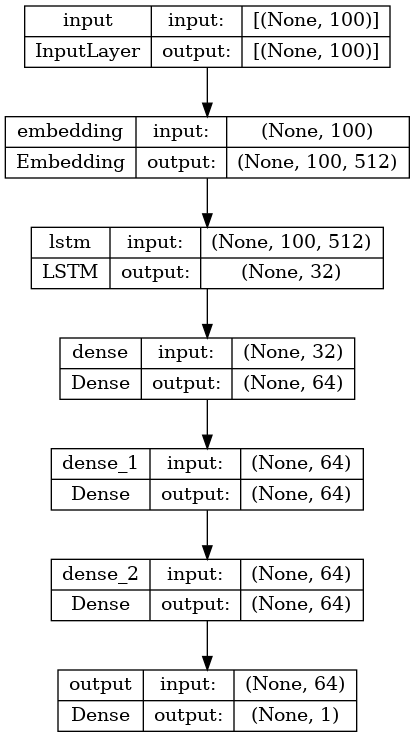

In [2]:
input = tf.keras.Input(shape=(100,), dtype='int32', name='input')
x = tf.keras.layers.Embedding(
    output_dim=512, input_dim=10000, input_length=100)(input)
x = tf.keras.layers.LSTM(32)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)
model = tf.keras.Model(inputs=[input], outputs=[output])
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [49]:
# tf.keras.losses.BinaryCrossentropy?

In [50]:
%%time

hist = input_model.fit(
    xt, y_train,
    epochs=1, 
    batch_size=32, 
    # validation_data=(padded_docs_test, y_test),
    # verbose=1,
    validation_split=0.2
)

782/782 [==============================] - 33s 41ms/step - loss: 0.3680 - accuracy: 0.2827 - precision: 0.5685 - recall: 0.1583 - val_loss: 0.3310 - val_accuracy: 0.3198 - val_precision: 0.6381 - val_recall: 0.2030
CPU times: user 32.9 s, sys: 771 ms, total: 33.6 s
Wall time: 33.1 s


In [42]:
y_pred = input_model.predict(np.array([[_] for _ in x_test]))

245/245 [==============================] - 1s 3ms/step


### We chose a threshold of 0.95 for a prediction array normalized by its maximum value in order to allow for multiple genres

In [43]:
new_y_pred = np.where((y_pred.T/y_pred.max(1)).T > 0.95, 1, 0)

In [44]:
from collections import Counter

Counter(new_y_pred.sum(1))

Counter({1: 6813, 2: 883, 3: 114, 4: 8})

### f1 micro avg is 0.47. 

In [45]:
print(classification_report(y_test, 
                            new_y_pred, 
                            output_dict=False,
                            target_names=classes))

              precision    recall  f1-score   support

      Action       0.39      0.11      0.17      1389
   Adventure       0.39      0.50      0.44      1245
   Animation       1.00      0.00      0.01       521
      Comedy       0.40      0.19      0.25      2514
       Crime       0.00      0.00      0.00      1022
       Drama       0.61      0.87      0.72      4000
      Family       0.00      0.00      0.00       795
     Fantasy       0.00      0.00      0.00       431
      Horror       0.43      0.00      0.01       846
     Romance       0.75      0.00      0.00      1467
      Sci-Fi       0.67      0.10      0.17       471
    Thriller       0.44      0.01      0.01      1417
         War       0.00      0.00      0.00       315
     Western       0.00      0.00      0.00       236

   micro avg       0.53      0.29      0.37     16669
   macro avg       0.36      0.13      0.13     16669
weighted avg       0.44      0.29      0.26     16669
 samples avg       0.56   

/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


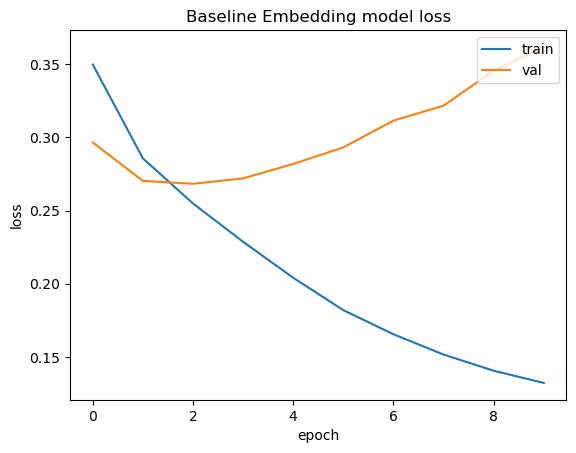

In [40]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Baseline Embedding model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

In [13]:
ak_model = ak.TextClassifier(
    multi_label=True,
    overwrite=True, 
    max_trials=1,
    project_name='ak_model_14_vanilla',
    metrics=METRICS,
    seed=SEED
) 

In [ ]:
_ = ak_model.tuner.get_best_hyperparameters()[0]
_.get_config()

In [288]:
base_model.compiled_loss.get_config()

{'losses': [{'module': 'keras.losses',
   'class_name': 'BinaryCrossentropy',
   'config': {'reduction': 'auto',
    'name': 'binary_crossentropy',
    'from_logits': False,
    'label_smoothing': 0.0,
    'axis': -1},
   'registered_name': None}],
 'total_loss_mean': {'module': 'keras.metrics',
  'class_name': 'Mean',
  'config': {'name': 'loss', 'dtype': 'float32'},
  'registered_name': None}}

In [281]:
base_model.optimizer.get_config()

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 0.001,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [256]:
# base_model.get_config()

In [257]:
# ak.TextBlock??

In [13]:
# input_node = ak.TextToIntSequence(max_tokens=max_tokens)



# output_node = ak.Normalization()(input_node)
# output_node1 = ak.ConvBlock()(output_node)
# output_node2 = ak.ResNetBlock(version="v2")(output_node)
# output_node = ak.Merge()([output_node1, output_node2])
# output_node = ak.ClassificationHead()(output_node)

# auto_model = ak.AutoModel(
#     inputs=input_node, 
#     outputs=output_node, 
#     overwrite=True, 
#     max_trials=1
# )






# ak_model = ak.TextClassifier(
#     multi_label=True,
#     overwrite=True, 
#     max_trials=1,
#     project_name='ak_model_14_vanilla',
#     metrics=METRICS,
#     seed=SEED
# ) 

In [258]:
# ak.AutoModel?

In [14]:
%time history = ak_model.fit(x_train, y_train, epochs=10)

Trial 1 Complete [00h 01m 56s]
val_loss: 0.27152201533317566

Best val_loss So Far: 0.27152201533317566
Total elapsed time: 00h 01m 56s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
978/978 [==============================] - 37s 37ms/step - loss: 0.3599 - accuracy: 0.3076 - precision: 0.5871 - recall: 0.2201
Epoch 2/10
978/978 [==============================] - 7s 7ms/step - loss: 0.2989 - accuracy: 0.3801 - precision: 0.6494 - recall: 0.3220
Epoch 3/10
978/978 [==============================] - 8s 8ms/step - loss: 0.2720 - accuracy: 0.4393 - precision: 0.6720 - recall: 0.4253
Epoch 4/10
978/978 [==============================] - 7s 8ms/step - loss: 0.2568 - accuracy: 0.4642 - precision: 0.6865 - recall: 0.4724
Epoch 5/10
978/978 [==============================] - 7s 7ms/step - loss: 0.2454 - accuracy: 0.4827 - precision: 0.7034 - recall: 0.5101
Epoch 6/10
978/978 [==============================] - 8s 8ms/step - loss: 0.2349 - accuracy: 0.4988 - precision: 0.7155 - recall: 0.5382
Ep

INFO:tensorflow:Assets written to: ./ak_model_14_vanilla/best_model/assets


INFO:tensorflow:Assets written to: ./ak_model_14_vanilla/best_model/assets


CPU times: user 4min 39s, sys: 15 s, total: 4min 54s
Wall time: 3min 44s


In [234]:
# base_model.save("model_autokeras.h5")

In [287]:
base_model = ak_model.export_model()
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLast  (None, 1)                0         
 Dim)                                                            
                                                                 
 text_vectorization (TextVec  (None, 512)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 512, 64)           320064    
                                                                 
 dropout (Dropout)           (None, 512, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 508, 256)          82176 

In [263]:
# base_model.save(f'{out_dir}/base_model')

INFO:tensorflow:Assets written to: out/base_model/assets


INFO:tensorflow:Assets written to: out/base_model/assets


In [264]:
base_model = keras.models.load_model(f'{out_dir}/base_model', custom_objects=ak.CUSTOM_OBJECTS)

In [265]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))

In [266]:
reinitialize(base_model)

/home/ivv101/miniconda3/envs/movie_classifier/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [280]:
%%time

hist = model.fit(
    x_train, y_train,
    epochs=10, 
    batch_size=32, 
    # validation_data=(padded_docs_test, y_test),
    # verbose=1,
    validation_split=0.2
)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [279]:
# base_model.get_config()

In [ ]:
a

In [261]:
base_model.reset_states??

Signature: base_model.reset_states()
Docstring: <no docstring>
Source:   
    def reset_states(self):
        for layer in self.layers:
            if hasattr(layer, "reset_states") and getattr(
                layer, "stateful", False
            ):
                layer.reset_states()
File:      ~/miniconda3/envs/movie_classifier/lib/python3.10/site-packages/keras/engine/training.py
Type:      method

In [222]:
hp = ak_model.tuner.get_best_hyperparameters()[0]

In [276]:
ak.keras_layers.ExpandLastDim?

Init signature: ak.keras_layers.ExpandLastDim(*args, **kwargs)
Docstring:     
Base class for Preprocessing Layers.

**Don't use this class directly: it's an abstract base class!** You may
be looking for one of the many built-in
[preprocessing layers](https://keras.io/guides/preprocessing_layers/)
instead.

Preprocessing layers are layers whose state gets computed before model
training starts. They do not get updated during training. Most
preprocessing layers implement an `adapt()` method for state computation.

The `PreprocessingLayer` class is the base class you would subclass to
implement your own preprocessing layers.
File:           ~/miniconda3/envs/movie_classifier/lib/python3.10/site-packages/autokeras/keras_layers.py
Type:           ABCMeta
Subclasses:     

In [225]:
hp.values

{'text_block_1/block_type': 'vanilla',
 'classification_head_1/dropout': 0,
 'text_block_1/max_tokens': 5000,
 'text_block_1/conv_block_1/separable': False,
 'text_block_1/text_to_int_sequence_1/output_sequence_length': 512,
 'text_block_1/embedding_1/pretraining': 'none',
 'text_block_1/embedding_1/embedding_dim': 64,
 'text_block_1/embedding_1/dropout': 0.25,
 'text_block_1/conv_block_1/kernel_size': 5,
 'text_block_1/conv_block_1/num_blocks': 1,
 'text_block_1/conv_block_1/num_layers': 1,
 'text_block_1/conv_block_1/max_pooling': False,
 'text_block_1/conv_block_1/dropout': 0,
 'text_block_1/conv_block_1/filters_0_0': 256,
 'text_block_1/spatial_reduction_1/reduction_type': 'global_max',
 'text_block_1/dense_block_1/num_layers': 1,
 'text_block_1/dense_block_1/use_batchnorm': False,
 'text_block_1/dense_block_1/dropout': 0.5,
 'text_block_1/dense_block_1/units_0': 256,
 'optimizer': 'adam',
 'learning_rate': 0.001}

In [270]:
y_pred = base_model.predict(x_test)

245/245 [==============================] - 1s 3ms/step


### We chose a threshold of 0.95 for a prediction array normalized by its maximum value in order to allow for multiple genres

In [271]:
new_y_pred = np.where((y_pred.T/y_pred.max(1)).T > 0.95, 1, 0)

In [272]:
from collections import Counter

Counter(new_y_pred.sum(1))

Counter({1: 6814, 2: 939, 3: 64, 4: 1})

### f1 micro avg is 0.47. 

In [273]:
print(classification_report(y_test, 
                            new_y_pred, 
                            output_dict=False,
                            target_names=classes))

              precision    recall  f1-score   support

      Action       0.58      0.30      0.39      1389
   Adventure       0.56      0.26      0.36      1245
   Animation       0.69      0.42      0.52       521
      Comedy       0.66      0.39      0.49      2514
       Crime       0.58      0.14      0.23      1022
       Drama       0.74      0.62      0.67      4000
      Family       0.56      0.15      0.23       795
     Fantasy       0.46      0.06      0.11       431
      Horror       0.72      0.62      0.66       846
     Romance       0.61      0.13      0.21      1467
      Sci-Fi       0.71      0.34      0.46       471
    Thriller       0.57      0.18      0.28      1417
         War       0.69      0.21      0.32       315
     Western       0.80      0.31      0.45       236

   micro avg       0.67      0.36      0.47     16669
   macro avg       0.64      0.30      0.39     16669
weighted avg       0.65      0.36      0.44     16669
 samples avg       0.68   

/home/ivv101/miniconda3/envs/movie_classifier/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print(classification_report(y_test, 
                            new_y_pred, 
                            output_dict=False,
                            target_names=classes))

              precision    recall  f1-score   support

      Action       0.59      0.36      0.45      1389
   Adventure       0.59      0.23      0.33      1245
   Animation       0.69      0.44      0.54       521
      Comedy       0.66      0.45      0.54      2514
       Crime       0.56      0.24      0.33      1022
       Drama       0.75      0.56      0.64      4000
      Family       0.66      0.18      0.28       795
     Fantasy       0.50      0.10      0.17       431
      Horror       0.70      0.63      0.66       846
     Romance       0.61      0.16      0.25      1467
      Sci-Fi       0.72      0.34      0.46       471
    Thriller       0.59      0.25      0.35      1417
         War       0.76      0.23      0.35       315
     Western       0.78      0.25      0.37       236

   micro avg       0.68      0.37      0.48     16669
   macro avg       0.65      0.31      0.41     16669
weighted avg       0.66      0.37      0.46     16669
 samples avg       0.69   

/home/ivv101/miniconda3/envs/movie_classifier/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
[_['config'] for _ in base_model.get_config()['layers']]

[{'batch_input_shape': (None,),
  'dtype': 'string',
  'sparse': False,
  'ragged': False,
  'name': 'input_1'},
 {'name': 'expand_last_dim', 'trainable': True, 'dtype': 'float32'},
 {'name': 'text_vectorization',
  'trainable': True,
  'dtype': 'string',
  'max_tokens': 5000,
  'standardize': 'lower_and_strip_punctuation',
  'split': 'whitespace',
  'ngrams': None,
  'output_mode': 'int',
  'output_sequence_length': 512,
  'pad_to_max_tokens': False,
  'sparse': False,
  'ragged': False,
  'vocabulary': None,
  'idf_weights': None,
  'encoding': 'utf-8'},
 {'name': 'embedding',
  'trainable': True,
  'dtype': 'float32',
  'batch_input_shape': (None, None),
  'input_dim': 5001,
  'output_dim': 64,
  'embeddings_initializer': {'class_name': 'RandomUniform',
   'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
  'embeddings_regularizer': None,
  'activity_regularizer': None,
  'embeddings_constraint': None,
  'mask_zero': False,
  'input_length': None},
 {'name': 'dropout',
  '

In [204]:
# keras.layers.Dense?

In [205]:
pred = input_model.predict(xt)

978/978 [==============================] - 4s 4ms/step


In [39]:
lay = base_model.layers[0]

In [44]:
lay.input

<KerasTensor: shape=(None,) dtype=string (created by layer 'input_1')>

In [ ]:
inputs = keras.layers.Input(shape=(20,))

x = inputs

# x = base_model.layers[1](x)
# x = base_model.layers[2](x)

x = keras.layers.Normalization()(x)

x = keras.layers.Dense(dense_units[0], activation='relu')(x)

x = keras.layers.Dropout(dropout_units[0])(x)

x = keras.layers.Dense(dense_units[1], activation='relu')(x)

x = keras.layers.Dropout(dropout_units[1])(x)

x = keras.layers.Dense(dense_units[2], activation='relu')(x)

x = keras.layers.Dropout(dropout_units[2])(x)

x = keras.layers.Dense(8, activation='softmax')(x)

new_model = keras.Model(inputs, x)

In [2]:
# np.sum(y_test * new_y_pred)/len(y_test)

In [87]:
# new_y_pred.sum(0).astype(int), np.unique(new_y_pred.sum(1).astype(int))

In [62]:
tf_model.save(f'{out_dir}/tf_model')

INFO:tensorflow:Assets written to: out/tf_model/assets


INFO:tensorflow:Assets written to: out/tf_model/assets


CPU times: user 739 ms, sys: 16.6 ms, total: 756 ms
Wall time: 751 ms


### In order to choose similar moview, we compute predictions for each movie with revenue > $10 million.

In [13]:
text_input_pred = tf_model.predict(text_input)

2023-01-23 08:59:14.896054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


  56/1222 [>.............................] - ETA: 3s

2023-01-23 08:59:15.956849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1222/1222 [==============================] - 6s 4ms/step


In [15]:
mask = df['revenue'] > 1e7
len(mask)

39086

In [16]:
df2 = df[mask]
text_input_pred2 = text_input_pred[mask]

In [17]:
out_data = df2[['name', 'year', 'genres']].to_dict(orient='list')
out_data['pred'] = text_input_pred2

out_data.keys()

dict_keys(['name', 'year', 'genres', 'pred'])

In [18]:
pkl.dump([classes, out_data], open(f'{out_dir}/aux_data.pkl', 'wb'))

### checking that spoiler database also produces a good f1 micro average

In [89]:
df_imdb = pkl.load(open(f'{tmp_dir}/df_imdb.pkl', 'rb'))
df_imdb

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis,clean
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",Jack Ryan is on a in London with his family. H...
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...,Four boys around the age of 10 are friends in ...
2,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...,Fred Dobbs and Bob Curtin are down on their lu...
3,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...,Jim McAllister is a much-admired high school h...
4,tt0286716,"Bruce Banner, a brilliant scientist with a clo...",2h 18min,"[Action, Sci-Fi]",5.7,2003-06-20,Bruce Banner (Eric Bana) is a research scienti...,Bruce Banner is a research scientist at a Berk...
...,...,...,...,...,...,...,...,...
1334,tt0120655,An abortion clinic worker with a special herit...,2h 10min,"[Adventure, Comedy, Drama]",7.3,1999-11-12,The film opens with a homeless man (Bud Cort) ...,The film opens with a homeless man on a desert...
1335,tt0276751,Twelve year old Marcus Brewer lives with his c...,1h 41min,"[Comedy, Drama, Romance]",7.1,2002-05-17,Will Freeman (Hugh Grant) is a 38-year-old bac...,Will Freeman is a 38-year-old bachelor who pri...
1336,tt0289879,Evan Treborn grows up in a small town with his...,1h 53min,"[Sci-Fi, Thriller]",7.7,2004-01-23,"In the year 1998, Evan Treborn (Ashton Kutcher...","In the year 1998, Evan Treborn who suffered se..."
1337,tt1723811,Brandon is a 30-something man living in New Yo...,1h 41min,[Drama],7.2,2012-01-13,"Brandon (Michael Fassbender) is a successful, ...","Brandon is a successful, handsome thirty-somet..."


In [90]:
imdb_labels = mlb.transform(df_imdb['genre'])

/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Biography', 'Film-Noir', 'History', 'Music', 'Musical', 'Mystery', 'Sport'] will be ignored
  warnings.warn(


In [91]:
y_pred = tf_model.predict(df_imdb['clean'].tolist())

42/42 [==============================] - 0s 7ms/step


In [93]:
new_y_pred = np.where((y_pred.T/y_pred.max(1)).T > 0.95, 1, 0)

In [94]:
# from collections import Counter

Counter(new_y_pred.sum(1))

Counter({2: 243, 1: 1076, 3: 20})

In [95]:
print(classification_report(imdb_labels, 
                            new_y_pred, 
                            output_dict=False,
                            target_names=classes))

              precision    recall  f1-score   support

      Action       0.66      0.38      0.49       394
   Adventure       0.68      0.34      0.45       387
   Animation       0.36      0.14      0.20        73
      Comedy       0.67      0.50      0.57       409
       Crime       0.82      0.22      0.35       252
       Drama       0.84      0.43      0.57       679
      Family       0.44      0.18      0.25       113
     Fantasy       0.33      0.04      0.08       161
      Horror       0.53      0.49      0.51       102
     Romance       0.74      0.15      0.25       194
      Sci-Fi       0.62      0.41      0.49       180
    Thriller       0.42      0.24      0.30       212
         War       0.64      0.30      0.41        23
     Western       0.50      0.20      0.29        10

   micro avg       0.67      0.34      0.45      3189
   macro avg       0.59      0.29      0.37      3189
weighted avg       0.67      0.34      0.44      3189
 samples avg       0.69   

/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
# single_genre = lambda y_pred : np.floor((y_pred.T/y_pred.T.max(0)).T).astype(int)